## Introducing Fire Reanalysis using Earthkit

**earthkit** is an **open-source** Python project led by ECMWF, providing powerful tools for speeding up weather and climate science workflows by simplifying **data access**, **processing**, **analysis**, **visualisation** and more.

**earthkit** lowers the barrier to entry for interacting with climate data in Python by providing high-level, easy-to-use functions for performing common data analysis and visualisation tasks. Designed to be **format-agnostic**, **earthkit** allows you to focus on working with whatever data you have without worrying about technical issues like data formats.

**earthkit** is currently in the *alpha* stage of development, but is already available in GitHub, PyPI and conda as an open-source project than can be installed, played with and contributed to. **earthkit** will become the recommended library for retrieving, analysing and visualising CDS and ADS data when it releases in 2024, replacing the legacy *CDS Toolbox*.

These notebooks provide an introduction to using earthkit as a one-stop-shop for speeding up your workflows for interacting with CDS data.

To get started, import the `earthkit` module.

In [1]:
import earthkit as ek
import os
from earthkit.data.testing import earthkit_remote_test_data_file
import pandas as pd
import xarray as xr
from datetime import datetime

### Retrieving data from the CDS

The core function we will be using for retrieving and opening data is `ek.data.from_source`. You can use this function to open data from many different sources, such as URLs, local files, and of course the CDS.

To access data from the CDS source, we need to pass `"cds"` as the first argument to `ek.data.from_source`. The other arguments are exactly the same arguments expected by the CDS API - that is, the name of the dataset followed by the request payload. If you're familiar with the **CDS API**, you'll already be acquainted with the syntax for these requests.

In the following example, we will retrieve data from the CDS dataset [ERA5 monthly averaged data on single levels from 1940 to present](https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels-monthly-means?tab=form). We will access monthly-averaged 2m temperature for the month of September 2022:

In [2]:

# If you are using the pre-downloaded data then please set DOWNLOAD_FROM_CDS to False
# and set the LOCAL_DATA_DIR to where you stored the data.

steps = [str(step) for step in range(12,5160,24)]
DOWNLOAD_FROM_CDS = False
LOCAL_DATA_DIR = "data/"
TARGET=f"{LOCAL_DATA_DIR}/fwinx_reanalysis.grib"
os.makedirs(LOCAL_DATA_DIR,exist_ok=True)

fwi_data = ek.data.from_source(
    "cds",
    "cems-fire-seasonal",
    variable= ["fire_weather_index"],
    release_version= "5",
    year= ["2024"],
    month= ["09"],
    day= ["01"],
    leadtime_hour=steps,
)

One advantage of **earthkit** over the legacy CDS API is that local downloads and caching are automatically handled for you. That means that you don't need to save your request to a specific file and then read that file into Python - it's all handled in one step. By default, files will be removed from your local cache after a few days - so you don't even need to worry about cleaning up files you no longer need, as they will be automatically housekept!

Note that we didn't include a `format` key in our request payload, even though ERA5 can be retrieved in either GRIB or netCDF format. **earthkit** is designed to be **format agnostic** - that is, earthkit tools should work in exactly the same way whether you have GRIB data *or* netCDF data, so we can comfortably exclude the data format from our request and accept the default selection made by the CDS.

The `data` object that has been returned from our CDS request is a special kind of **earthkit** object, providing a range of convenient methods for interrogating a data source or converting it to a format that's familiar to you, such as xarray, numpy or pandas - or saving to a local file.

In [3]:
fwi_data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,fwinx,surface,0,20240901,0,None,fc,0,regular_ll
1,ecmf,fwinx,surface,0,20240901,0,None,fc,1,regular_ll
2,ecmf,fwinx,surface,0,20240901,0,None,fc,2,regular_ll
3,ecmf,fwinx,surface,0,20240901,0,None,fc,3,regular_ll
4,ecmf,fwinx,surface,0,20240901,0,None,fc,4,regular_ll
...,...,...,...,...,...,...,...,...,...,...
10960,ecmf,fwinx,surface,0,20240901,0,None,fc,46,regular_ll
10961,ecmf,fwinx,surface,0,20240901,0,None,fc,47,regular_ll
10962,ecmf,fwinx,surface,0,20240901,0,None,fc,48,regular_ll
10963,ecmf,fwinx,surface,0,20240901,0,None,fc,49,regular_ll


In [4]:
# Convert to an xarray Dataset object
xfwi_data = fwi_data.to_xarray()
xfwi_data = xfwi_data.assign_coords(longitude=(((xfwi_data.longitude + 180) % 360) - 180)).sortby('longitude')
print(xfwi_data)    

<xarray.Dataset> Size: 6GB
Dimensions:    (number: 51, step: 215, latitude: 181, longitude: 360)
Coordinates:
  * number     (number) int64 408B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * step       (step) timedelta64[ns] 2kB 0 days 12:00:00 ... 214 days 12:00:00
  * latitude   (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude  (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
Data variables:
    fwinx      (number, step, latitude, longitude) float64 6GB ...
Attributes: (12/13)
    param:        fwinx
    class:        gw
    stream:       mmsf
    levtype:      sfc
    type:         fc
    expver:       0001
    ...           ...
    time:         0
    origin:       ecmf_od
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF


In [5]:
start_date=datetime.strptime(str(xfwi_data.date)+'12',"%Y%m%d%H")
times = pd.date_range(start_date.strftime("%Y/%m/%d"),start_date.strftime("%Y/%m/%d"),freq='D')
time_da = xr.DataArray(times, [('time', times)])
xfwi_data2=xfwi_data.expand_dims(time=time_da)
xfwi_data2.coords["valid_time"] = (
    xfwi_data2["time"] + xfwi_data2["step"]
)
del xfwi_data
xfwi_data2

<xarray.Dataset> Size: 6GB
Dimensions:     (time: 1, number: 51, step: 215, latitude: 181, longitude: 360)
Coordinates:
  * time        (time) datetime64[ns] 8B 2024-09-01
  * number      (number) int64 408B 0 1 2 3 4 5 6 7 ... 43 44 45 46 47 48 49 50
  * step        (step) timedelta64[ns] 2kB 0 days 12:00:00 ... 214 days 12:00:00
  * latitude    (latitude) float64 1kB 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * longitude   (longitude) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0
    valid_time  (time, step) datetime64[ns] 2kB 2024-09-01T12:00:00 ... 2025-...
Data variables:
    fwinx       (time, number, step, latitude, longitude) float64 6GB nan ......
Attributes: (12/13)
    param:        fwinx
    class:        gw
    stream:       mmsf
    levtype:      sfc
    type:         fc
    expver:       0001
    ...           ...
    time:         0
    origin:       ecmf_od
    domain:       g
    method:       1
    Conventions:  CF-1.8
    institution:  ECMWF

In [6]:
# Use some demonstration polygons stored, this could be any url or path to geojson file
remote_nuts_url = earthkit_remote_test_data_file("test-data", "NUTS_RG_60M_2021_4326_LEVL_0.geojson")
nuts_data = ek.data.from_source("url", remote_nuts_url)

nuts_data.to_pandas()[:5]

NUTS_RG_60M_2021_4326_LEVL_0.geojson:   0%|          | 0.00/68.4k [00:00<?, ?B/s]

,id,NUTS_ID,LEVL_CODE,CNTR_CODE,NAME_LATN,NUTS_NAME,MOUNT_TYPE,URBN_TYPE,COAST_TYPE,FID,geometry
0,DK,DK,0,DK,Danmark,Danmark,0,0,0,DK,"MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996..."
1,RS,RS,0,RS,Serbia,Srbija/Сpбија,0,0,0,RS,"POLYGON ((21.4792 45.193, 21.3585 44.8216, 22...."
2,EE,EE,0,EE,Eesti,Eesti,0,0,0,EE,"MULTIPOLYGON (((27.357 58.7871, 27.6449 57.981..."
3,EL,EL,0,EL,Elláda,Ελλάδα,0,0,0,EL,"MULTIPOLYGON (((28.0777 36.1182, 27.8606 35.92..."
4,ES,ES,0,ES,España,España,0,0,0,ES,"MULTIPOLYGON (((4.391 39.8617, 4.1907 39.7981,..."


In [7]:
reduced_data_pd = ek.transforms.aggregate.spatial.reduce(xfwi_data2, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims=["time"])
reduced_data_pd[:10]

id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN  \
FID number step                                                         
DK  0      0 days 12:00:00  DK      DK          0        DK   Danmark   
           1 days 12:00:00  DK      DK          0        DK   Danmark   
           2 days 12:00:00  DK      DK          0        DK   Danmark   
           3 days 12:00:00  DK      DK          0        DK   Danmark   
           4 days 12:00:00  DK      DK          0        DK   Danmark   
           5 days 12:00:00  DK      DK          0        DK   Danmark   
           6 days 12:00:00  DK      DK          0        DK   Danmark   
           7 days 12:00:00  DK      DK          0        DK   Danmark   
           8 days 12:00:00  DK      DK          0        DK   Danmark   
           9 days 12:00:00  DK      DK          0        DK   Danmark   

                           NUTS_NAME  MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID number step                                                               
DK  0      0 days 12:00:00   Danmark           0          0           0  DK   
           1 days 12:00:00   Danmark           0          0           0  DK   
           2 days 12:00:00   Danmark           0          0           0  DK   
           3 days 12:00:00   Danmark           0          0           0  DK   
           4 days 12:00:00   Danmark           0          0           0  DK   
           5 days 12:00:00   Danmark           0          0           0  DK   
           6 days 12:00:00   Danmark           0          0           0  DK   
           7 days 12:00:00   Danmark           0          0           0  DK   
           8 days 12:00:00   Danmark           0          0           0  DK   
           9 days 12:00:00   Danmark           0          0           0  DK   

                                                                     geometry  \
FID number step                                                                 
DK  0      0 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           1 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           2 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           3 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           4 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           5 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           6 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           7 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           8 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   
           9 days 12:00:00  MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   

                               fwinx  
FID number step                       
DK  0      0 days 12:00:00  5.873884  
           1 days 12:00:00  7.741629  
           2 days 12:00:00  5.392857  
           3 days 12:00:00  4.162946  
           4 days 12:00:00  5.603237  
           5 days 12:00:00  6.044643  
           6 days 12:00:00  4.445871  
           7 days 12:00:00  3.943638  
           8 days 12:00:00  4.959821  
           9 days 12:00:00  5.983259

In [8]:
# reduced_data = ek.transforms.aggregate.spatial.reduce(xfwi_data2, nuts_data, extra_reduce_dims=['time','number'])
fwi_monthly_average_per_mem = ek.transforms.aggregate.temporal.monthly_mean(xfwi_data2,time_dim="valid_time")

reduced_data_pd = ek.transforms.aggregate.spatial.reduce(fwi_monthly_average_per_mem, nuts_data, return_as="pandas", mask_dim="FID", extra_reduce_dims=["number"])
reduced_data_pd[:10]

id NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN      NUTS_NAME  \
FID year_months                                                             
DK  0            DK      DK          0        DK   Danmark        Danmark   
    1            DK      DK          0        DK   Danmark        Danmark   
    2            DK      DK          0        DK   Danmark        Danmark   
    3            DK      DK          0        DK   Danmark        Danmark   
    4            DK      DK          0        DK   Danmark        Danmark   
    5            DK      DK          0        DK   Danmark        Danmark   
    6            DK      DK          0        DK   Danmark        Danmark   
    7            DK      DK          0        DK   Danmark        Danmark   
RS  0            RS      RS          0        RS    Serbia  Srbija/Сpбија   
    1            RS      RS          0        RS    Serbia  Srbija/Сpбија   

                 MOUNT_TYPE  URBN_TYPE  COAST_TYPE FID  \
FID year_months                                          
DK  0                     0          0           0  DK   
    1                     0          0           0  DK   
    2                     0          0           0  DK   
    3                     0          0           0  DK   
    4                     0          0           0  DK   
    5                     0          0           0  DK   
    6                     0          0           0  DK   
    7                     0          0           0  DK   
RS  0                     0          0           0  RS   
    1                     0          0           0  RS   

                                                          geometry      fwinx  
FID year_months                                                                
DK  0            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   4.406079  
    1            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   2.548951  
    2            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   0.948145  
    3            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   0.460569  
    4            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   0.419379  
    5            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   0.538353  
    6            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   1.335384  
    7            MULTIPOLYGON (((15.1629 55.0937, 15.094 54.996...   1.692223  
RS  0            POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....  20.838675  
    1            POLYGON ((21.4792 45.193, 21.3585 44.8216, 22....  12.001399

<Axes: >

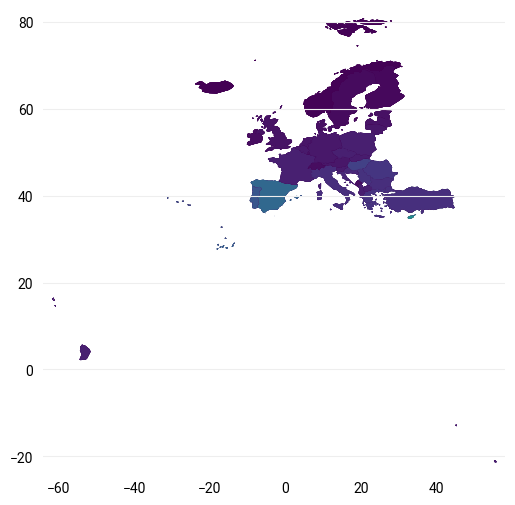

In [9]:
reduced_data_pd.plot("fwinx")

### Quick visualisation with **earthkit-maps**

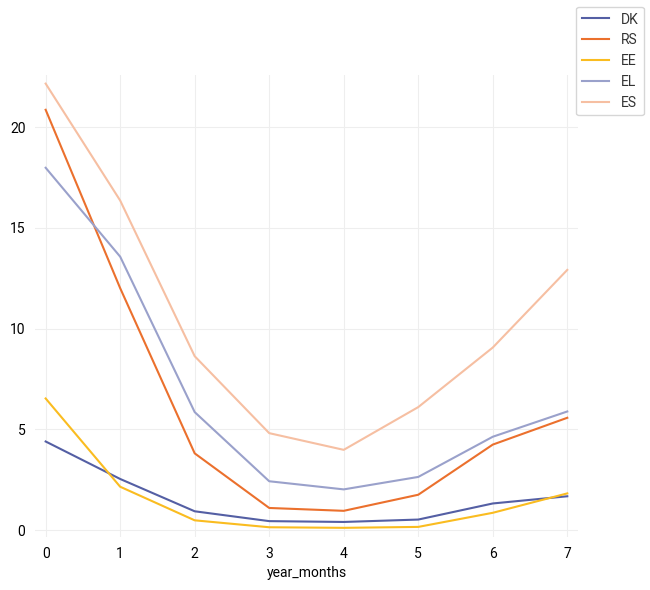

In [11]:
import matplotlib.pyplot as plt
feature_index = "FID"
plot_var = "fwinx"
fig, ax = plt.subplots(1)
for feature in reduced_data_pd.index.get_level_values(feature_index).unique()[:5]:
    temp = reduced_data_pd.xs(feature, level=feature_index)
    temp[plot_var].plot(ax=ax, label=feature)
fig.legend()